In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple


In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000


In [7]:
data_dir = pathlib.Path('Melody RNN')




In [8]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))


Number of files: 7


In [9]:
sample_file = filenames[1]
print(sample_file)


Melody RNN/dataset/4.mid


In [12]:
pm = pretty_midi.PrettyMIDI(sample_file)


/home/developer/.local/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [13]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)


In [14]:
display_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


In [15]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)


Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [16]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')


0: pitch=35, note_name=B1, duration=0.2500
1: pitch=75, note_name=D#5, duration=0.5000
2: pitch=47, note_name=B2, duration=0.2500
3: pitch=35, note_name=B1, duration=0.2500
4: pitch=71, note_name=B4, duration=0.1250
5: pitch=47, note_name=B2, duration=0.2500
6: pitch=75, note_name=D#5, duration=0.1250
7: pitch=37, note_name=C#2, duration=0.2500
8: pitch=49, note_name=C#3, duration=0.2500
9: pitch=77, note_name=F5, duration=0.5000


In [17]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})


In [18]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()


,pitch,start,end,step,duration
0,35,0.00,0.250,0.00,0.250
1,75,0.00,0.500,0.00,0.500
2,47,0.25,0.500,0.25,0.250
3,35,0.50,0.750,0.25,0.250
4,71,0.75,0.875,0.25,0.125


In [19]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]


array(['B1', 'D#5', 'B2', 'B1', 'B4', 'B2', 'D#5', 'C#2', 'F5', 'C#3'],
      dtype='<U3')

In [20]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)


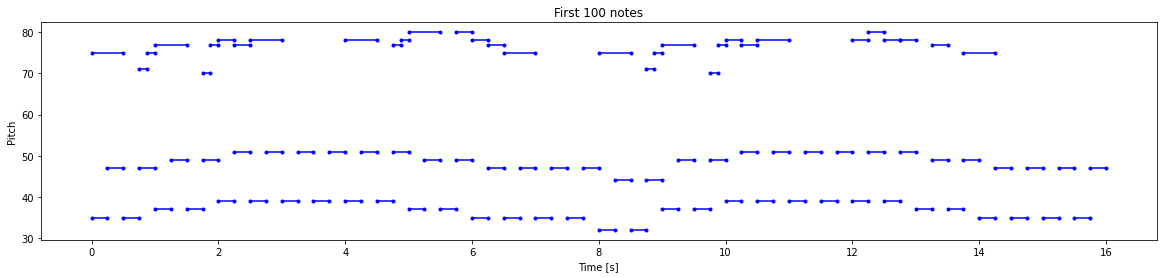

In [21]:
plot_piano_roll(raw_notes, count=100)


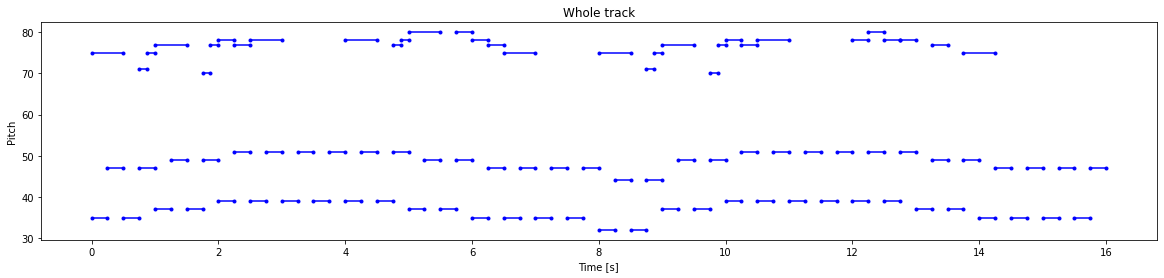

In [22]:
plot_piano_roll(raw_notes)


In [23]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))


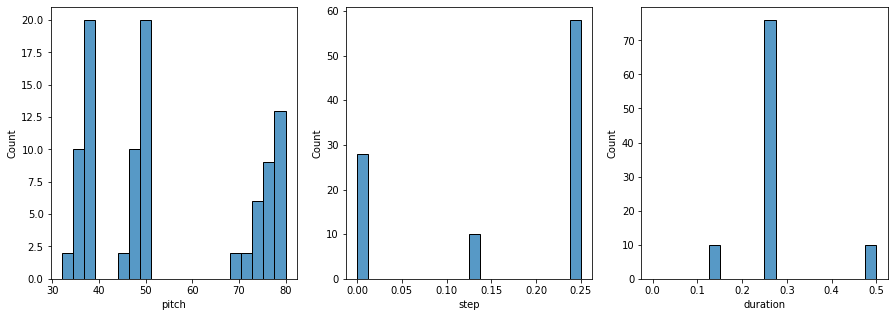

In [24]:
plot_distributions(raw_notes)
